<a href="https://colab.research.google.com/github/emmanuel-olateju/EmotiSpot/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d khan1803115/eeg-dataset-for-emotion-recognition
!mkdir -p datasets/khan1803115
!unzip eeg-dataset-for-emotion-recognition.zip -d datasets/khan1803115/
!rm eeg-dataset-for-emotion-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/khan1803115/eeg-dataset-for-emotion-recognition
License(s): Apache 2.0
 89% 161M/181M [00:01<00:00, 141MB/s]
100% 181M/181M [00:01<00:00, 121MB/s]
Archive:  eeg-dataset-for-emotion-recognition.zip
  inflating: datasets/khan1803115/Data/S01G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G4AllChannels.csv  
  inflating: d

In [2]:
import os

import numpy as np
import pandas as pd
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.1 MB/s eta 0:00:00


In [3]:
import joblib
# from google.colab import files

def save_artifact(artifact,name):
  joblib.dump(artifact,name)
  # files.download(name)


## Data Loading

In [4]:
khan_dataset_dir = "datasets/khan1803115/"
valence = pd.read_csv(khan_dataset_dir+"valence_normalize.csv")
arousal = pd.read_csv(khan_dataset_dir+"arousal_normalize.csv")
data = [pd.read_csv(khan_dataset_dir+"Data/"+file) for file in os.listdir(khan_dataset_dir+"Data/")]

channels = data[0].columns[:-2]
label_columns = data[0].columns[-2:]
fs = 128

In [5]:
eeg_data = np.array([data_[channels][:38000] for data_ in data])
valence_arousal_values = np.array([data_[label_columns].mean() for data_ in data])
eeg_data.shape, valence_arousal_values.shape

((100, 38000, 14), (100, 2))

In [6]:
# Make use of 1280 samples for an epoch with 0 samples overlapping between succesive epochs
epoch_starting_points = np.arange(0,38252,1280-0)[:-4]

eeg_epochs = []

for i in range(len(data)):
    epochs = []
    for epoch_starting_point in epoch_starting_points:
        epochs.append(eeg_data[i,epoch_starting_point:epoch_starting_point+1280,:])

    eeg_epochs.append(epochs)

eeg_epochs = np.array(eeg_epochs)

eeg_epochs.shape

(100, 26, 1280, 14)

In [7]:
epoch_targets = []

for i in range(len(data)):
  targets = [valence_arousal_values[i]]*26
  epoch_targets.append(targets)

epoch_targets = np.array(epoch_targets)

epoch_targets.shape

(100, 26, 2)

In [8]:
eeg_epochs = eeg_epochs.reshape(2600,1280,14)
epoch_targets = epoch_targets.reshape(2600,2)

eeg_epochs.shape, epoch_targets.shape

((2600, 1280, 14), (2600, 2))

In [ ]:
# save_artifact(eeg_epochs,"EEG_DATA.np")

## Preprocessing

In [9]:
lowcut = 1
highcut = 45

filtered_eeg_epochs = np.empty((2600,1280,14))

for e,epoch in enumerate(eeg_epochs):
  filtered = mne.filter.filter_data(epoch.T,fs,lowcut,highcut,verbose=0)
  filtered_eeg_epochs[e,:,:] = filtered.T

filtered_eeg_epochs.shape

(2600, 1280, 14)

In [ ]:
# save_artifact(filtered_eeg_epochs,"FILTERED_EEG_DATA.np")
# save_artifact(epoch_targets,"EEG_VALENCE_AROUSAL_TARGETS.np")

## Make Dataloader

In [10]:
import random

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# Set the device
device_ = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device_}")

# Set the device globally
# torch.set_default_device(device_)

Current Device: cpu


In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, features, targets, transform=None, device__="cpu"):
    self.features = torch.tensor(features,device=device__)
    self.targets = torch.tensor(targets,device=device__)
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    feature = self.features[idx,::]
    target = self.targets[idx]
    if self.transform:
      feature = self.transform(feature)
    return feature, target

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

random.seed(120)
torch.manual_seed(120)

X, y = filtered_eeg_epochs, epoch_targets

# feature_scaler = MinMaxScaler()
# y = feature_scaler.fit_transform(y)


X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.20, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=100)

for i in range(len(X_train)):
  scaler = StandardScaler()
  X_train[i,::] = scaler.fit_transform(X_train[i,::])

for i in range(len(X_test)):
  scaler = StandardScaler()
  X_test[i,::] = scaler.fit_transform(X_test[i,::])

for i in range(len(X_val)):
  scaler = StandardScaler()
  X_val[i,::] = scaler.fit_transform(X_val[i,::])

feature_scaler = MinMaxScaler()
y_train = feature_scaler.fit_transform(y_train)
y_test = feature_scaler.transform(y_test)
y_val = feature_scaler.transform(y_val)

print(f" Train Size :({X_train.shape}, {y_train.shape}) | Test Size : ({X_test.shape}, {y_test.shape}) | Validation Size: ({X_val.shape}, {y_val.shape})")

train_batch_size = 204
shuffle_ = True
num_workers_ = 5

# Make Train Dataloader
train_dataset = CustomDataset(X_train.astype(float),y_train.astype(float))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=shuffle_, num_workers=num_workers_)

# Make Validation Dataloader
val_batch_size = 34
val_dataset = CustomDataset(X_val.astype(float),y_val.astype(float))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=shuffle_, num_workers=num_workers_)

X_train = torch.tensor(X_train).to(torch.float)
y_train = torch.tensor(y_train).to(torch.float)
X_train = X_train.to(device_)
y_train = y_train.to(device_)

X_test = torch.tensor(X_test).to(torch.float)
y_test = torch.tensor(y_test).to(torch.float)
X_test = X_test.to(device_)
y_test = y_test.to(device_)

X_val = torch.tensor(X_val).to(torch.float)
y_val = torch.tensor(y_val).to(torch.float)
X_val = X_val.to(device_)
y_val = y_val.to(device_)

 Train Size :((2080, 1280, 14), (2080, 2)) | Test Size : ((260, 1280, 14), (260, 2)) | Validation Size: ((260, 1280, 14), (260, 2))


## Modelling

In [53]:
class mlp(nn.Module):

  def __init__(self):
    super(mlp,self).__init__()

    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1280*14,1000),
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.Linear(1000,1000),
        nn.Sigmoid(),
        nn.Linear(1000,100),
        nn.Sigmoid(),
        nn.Linear(100,2),
        nn.Sigmoid(),
        nn.Linear(2,2),
        nn.ReLU()
    )


  def forward(self,x):

    x = x.view(x.size()[0],-1)
    x = self.fc1(x.to(torch.float32))

    return x

class cnn(nn.Module):

  def __init__(self):
    super(cnn,self).__init__()

    self.conv = nn.Sequential(
      nn.Dropout(0.1),
      nn.BatchNorm1d(14),
      nn.Conv1d(14,14,kernel_size=64,stride=2,padding=0), # OUTPUT: C=14, L=609
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=3,stride=2), # OUTPUT: C=14, L=304
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
      nn.Conv1d(14,14,kernel_size=2,stride=2,padding=0), #OUTPUT: C=14, L=152
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=5,stride=7), # OUTPUT: C=14, L=22
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
    )

    self.fc = nn.Sequential(
        # nn.Dropout(0.05),
        nn.Linear(14*22,98),
        nn.ReLU(),
        nn.BatchNorm1d(98),
        nn.Linear(98,50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,2),
        nn.ReLU()
    )

  def forward(self,x):
    x = torch.transpose(x,1,2)
    x = self.conv(x)
    x = x.view(x.size()[0],-1)
    x = self.fc(x)

    return x


def r_squared(predicted, target):
    # Compute the mean of the target tensor
    target_mean = torch.mean(target)

    # Compute the total sum of squares (TSS)
    tss = torch.sum((target - target_mean) ** 2)

    # Compute the residual sum of squares (RSS)
    rss = torch.sum((target - predicted) ** 2)

    # Compute R-squared
    r_squared = 1 - (rss / tss)

    return r_squared


In [51]:
# torch.backends.cuda.cufft_plan_cache[0].max_size = 0

torch.Size([260, 2])

  0%|          | 1/600 [00:00<03:01,  3.29it/s]

----------------------------------------------------------------------------------
Epoch: 0/600 | loss: 1.55 |  validation loss: 1.52 | learning rate: [0.001]


  0%|          | 2/600 [00:00<02:47,  3.57it/s]

----------------------------------------------------------------------------------
Epoch: 1/600 | loss: 1.51 |  validation loss: 1.51 | learning rate: [0.001]


  0%|          | 3/600 [00:00<02:45,  3.61it/s]

----------------------------------------------------------------------------------
Epoch: 2/600 | loss: 1.49 |  validation loss: 1.51 | learning rate: [0.001]


  1%|          | 4/600 [00:01<02:42,  3.68it/s]

----------------------------------------------------------------------------------
Epoch: 3/600 | loss: 1.47 |  validation loss: 1.48 | learning rate: [0.001]


  1%|          | 5/600 [00:01<02:37,  3.79it/s]

----------------------------------------------------------------------------------
Epoch: 4/600 | loss: 1.45 |  validation loss: 1.46 | learning rate: [0.001]


  1%|          | 6/600 [00:01<02:32,  3.90it/s]

----------------------------------------------------------------------------------
Epoch: 5/600 | loss: 1.44 |  validation loss: 1.44 | learning rate: [0.001]


  1%|          | 7/600 [00:01<02:25,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 6/600 | loss: 1.41 |  validation loss: 1.41 | learning rate: [0.001]


  1%|▏         | 8/600 [00:02<02:22,  4.15it/s]

----------------------------------------------------------------------------------
Epoch: 7/600 | loss: 1.39 |  validation loss: 1.39 | learning rate: [0.001]


  2%|▏         | 9/600 [00:02<02:20,  4.20it/s]

----------------------------------------------------------------------------------
Epoch: 8/600 | loss: 1.38 |  validation loss: 1.38 | learning rate: [0.001]


  2%|▏         | 10/600 [00:02<02:15,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 9/600 | loss: 1.37 |  validation loss: 1.35 | learning rate: [0.001]


  2%|▏         | 11/600 [00:02<02:13,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 10/600 | loss: 1.35 |  validation loss: 1.33 | learning rate: [0.001]


  2%|▏         | 12/600 [00:02<02:13,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 11/600 | loss: 1.33 |  validation loss: 1.31 | learning rate: [0.001]


  2%|▏         | 13/600 [00:03<02:12,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 12/600 | loss: 1.31 |  validation loss: 1.31 | learning rate: [0.001]


  2%|▏         | 14/600 [00:03<02:10,  4.48it/s]

----------------------------------------------------------------------------------
Epoch: 13/600 | loss: 1.30 |  validation loss: 1.28 | learning rate: [0.001]


  2%|▎         | 15/600 [00:03<02:12,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 14/600 | loss: 1.28 |  validation loss: 1.26 | learning rate: [0.001]


  3%|▎         | 16/600 [00:03<02:11,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 15/600 | loss: 1.26 |  validation loss: 1.25 | learning rate: [0.001]


  3%|▎         | 17/600 [00:04<02:12,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 16/600 | loss: 1.25 |  validation loss: 1.24 | learning rate: [0.001]


  3%|▎         | 18/600 [00:04<02:12,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 17/600 | loss: 1.24 |  validation loss: 1.22 | learning rate: [0.001]


  3%|▎         | 19/600 [00:04<02:12,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 18/600 | loss: 1.22 |  validation loss: 1.21 | learning rate: [0.001]


  3%|▎         | 20/600 [00:04<02:13,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 19/600 | loss: 1.20 |  validation loss: 1.20 | learning rate: [0.001]


  4%|▎         | 21/600 [00:04<02:13,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 20/600 | loss: 1.19 |  validation loss: 1.18 | learning rate: [0.001]


  4%|▎         | 22/600 [00:05<02:15,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 21/600 | loss: 1.18 |  validation loss: 1.17 | learning rate: [0.001]


  4%|▍         | 23/600 [00:05<02:13,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 22/600 | loss: 1.17 |  validation loss: 1.16 | learning rate: [0.001]


  4%|▍         | 24/600 [00:05<02:13,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 23/600 | loss: 1.15 |  validation loss: 1.15 | learning rate: [0.001]


  4%|▍         | 25/600 [00:05<02:12,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 24/600 | loss: 1.14 |  validation loss: 1.14 | learning rate: [0.001]


  4%|▍         | 26/600 [00:06<02:12,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 25/600 | loss: 1.13 |  validation loss: 1.12 | learning rate: [0.001]


  4%|▍         | 27/600 [00:06<02:11,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 26/600 | loss: 1.12 |  validation loss: 1.11 | learning rate: [0.001]


  5%|▍         | 28/600 [00:06<02:10,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 27/600 | loss: 1.10 |  validation loss: 1.10 | learning rate: [0.001]


  5%|▍         | 29/600 [00:06<02:11,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 28/600 | loss: 1.09 |  validation loss: 1.09 | learning rate: [0.001]


  5%|▌         | 30/600 [00:07<02:09,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 29/600 | loss: 1.08 |  validation loss: 1.08 | learning rate: [0.001]


  5%|▌         | 31/600 [00:07<02:08,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 30/600 | loss: 1.07 |  validation loss: 1.07 | learning rate: [0.001]


  5%|▌         | 32/600 [00:07<02:07,  4.46it/s]

----------------------------------------------------------------------------------
Epoch: 31/600 | loss: 1.06 |  validation loss: 1.06 | learning rate: [0.001]


  6%|▌         | 33/600 [00:07<02:08,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 32/600 | loss: 1.05 |  validation loss: 1.06 | learning rate: [0.001]


  6%|▌         | 34/600 [00:07<02:09,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 33/600 | loss: 1.04 |  validation loss: 1.05 | learning rate: [0.001]


  6%|▌         | 35/600 [00:08<02:09,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 34/600 | loss: 1.03 |  validation loss: 1.04 | learning rate: [0.001]


  6%|▌         | 36/600 [00:08<02:07,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 35/600 | loss: 1.02 |  validation loss: 1.03 | learning rate: [0.001]


  6%|▌         | 37/600 [00:08<02:07,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 36/600 | loss: 1.01 |  validation loss: 1.01 | learning rate: [0.001]


  6%|▋         | 38/600 [00:08<02:07,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 37/600 | loss: 1.00 |  validation loss: 1.02 | learning rate: [0.001]


  6%|▋         | 39/600 [00:09<02:12,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 38/600 | loss: 0.99 |  validation loss: 1.00 | learning rate: [0.001]


  7%|▋         | 40/600 [00:09<02:09,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 39/600 | loss: 0.99 |  validation loss: 0.99 | learning rate: [0.001]


  7%|▋         | 41/600 [00:09<02:08,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 40/600 | loss: 0.98 |  validation loss: 0.97 | learning rate: [0.001]


  7%|▋         | 42/600 [00:09<02:09,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 41/600 | loss: 0.96 |  validation loss: 0.96 | learning rate: [0.001]


  7%|▋         | 43/600 [00:10<02:10,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 42/600 | loss: 0.96 |  validation loss: 0.96 | learning rate: [0.001]


  7%|▋         | 44/600 [00:10<02:08,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 43/600 | loss: 0.95 |  validation loss: 0.94 | learning rate: [0.001]


  8%|▊         | 45/600 [00:10<02:05,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 44/600 | loss: 0.94 |  validation loss: 0.94 | learning rate: [0.001]


  8%|▊         | 46/600 [00:10<02:06,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 45/600 | loss: 0.93 |  validation loss: 0.93 | learning rate: [0.001]


  8%|▊         | 47/600 [00:10<02:05,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 46/600 | loss: 0.92 |  validation loss: 0.91 | learning rate: [0.001]


  8%|▊         | 48/600 [00:11<02:04,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 47/600 | loss: 0.91 |  validation loss: 0.91 | learning rate: [0.001]


  8%|▊         | 49/600 [00:11<02:05,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 48/600 | loss: 0.91 |  validation loss: 0.89 | learning rate: [0.001]


  8%|▊         | 50/600 [00:11<02:05,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 49/600 | loss: 0.90 |  validation loss: 0.89 | learning rate: [0.001]


  8%|▊         | 51/600 [00:11<02:07,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 50/600 | loss: 0.89 |  validation loss: 0.89 | learning rate: [0.001]


  9%|▊         | 52/600 [00:12<02:07,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 51/600 | loss: 0.88 |  validation loss: 0.87 | learning rate: [0.001]


  9%|▉         | 53/600 [00:12<02:06,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 52/600 | loss: 0.88 |  validation loss: 0.87 | learning rate: [0.001]


  9%|▉         | 54/600 [00:12<02:06,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 53/600 | loss: 0.87 |  validation loss: 0.86 | learning rate: [0.001]


  9%|▉         | 55/600 [00:12<02:06,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 54/600 | loss: 0.86 |  validation loss: 0.85 | learning rate: [0.001]


  9%|▉         | 56/600 [00:13<02:05,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 55/600 | loss: 0.85 |  validation loss: 0.85 | learning rate: [0.001]


 10%|▉         | 57/600 [00:13<02:05,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 56/600 | loss: 0.85 |  validation loss: 0.84 | learning rate: [0.001]


 10%|▉         | 58/600 [00:13<02:04,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 57/600 | loss: 0.84 |  validation loss: 0.84 | learning rate: [0.001]


 10%|▉         | 59/600 [00:13<02:05,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 58/600 | loss: 0.84 |  validation loss: 0.82 | learning rate: [0.001]


 10%|█         | 60/600 [00:13<02:04,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 59/600 | loss: 0.83 |  validation loss: 0.82 | learning rate: [0.001]


 10%|█         | 61/600 [00:14<02:04,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 60/600 | loss: 0.82 |  validation loss: 0.81 | learning rate: [0.001]


 10%|█         | 62/600 [00:14<02:04,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 61/600 | loss: 0.81 |  validation loss: 0.81 | learning rate: [0.001]


 10%|█         | 63/600 [00:14<02:08,  4.18it/s]

----------------------------------------------------------------------------------
Epoch: 62/600 | loss: 0.80 |  validation loss: 0.81 | learning rate: [0.001]


 11%|█         | 64/600 [00:14<02:14,  3.99it/s]

----------------------------------------------------------------------------------
Epoch: 63/600 | loss: 0.80 |  validation loss: 0.82 | learning rate: [0.001]


 11%|█         | 65/600 [00:15<02:14,  3.98it/s]

----------------------------------------------------------------------------------
Epoch: 64/600 | loss: 0.80 |  validation loss: 0.80 | learning rate: [0.001]


 11%|█         | 66/600 [00:15<02:11,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 65/600 | loss: 0.79 |  validation loss: 0.79 | learning rate: [0.001]


 11%|█         | 67/600 [00:15<02:09,  4.12it/s]

----------------------------------------------------------------------------------
Epoch: 66/600 | loss: 0.78 |  validation loss: 0.79 | learning rate: [0.001]


 11%|█▏        | 68/600 [00:15<02:05,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 67/600 | loss: 0.77 |  validation loss: 0.77 | learning rate: [0.001]


 12%|█▏        | 69/600 [00:16<02:05,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 68/600 | loss: 0.77 |  validation loss: 0.77 | learning rate: [0.001]


 12%|█▏        | 70/600 [00:16<02:03,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 69/600 | loss: 0.76 |  validation loss: 0.76 | learning rate: [0.001]


 12%|█▏        | 71/600 [00:16<02:02,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 70/600 | loss: 0.76 |  validation loss: 0.75 | learning rate: [0.001]


 12%|█▏        | 72/600 [00:16<01:59,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 71/600 | loss: 0.75 |  validation loss: 0.75 | learning rate: [0.001]


 12%|█▏        | 73/600 [00:17<01:58,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 72/600 | loss: 0.75 |  validation loss: 0.75 | learning rate: [0.001]


 12%|█▏        | 74/600 [00:17<01:58,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 73/600 | loss: 0.74 |  validation loss: 0.74 | learning rate: [0.001]


 12%|█▎        | 75/600 [00:17<01:57,  4.47it/s]

----------------------------------------------------------------------------------
Epoch: 74/600 | loss: 0.73 |  validation loss: 0.73 | learning rate: [0.001]


 13%|█▎        | 76/600 [00:17<01:56,  4.49it/s]

----------------------------------------------------------------------------------
Epoch: 75/600 | loss: 0.73 |  validation loss: 0.73 | learning rate: [0.001]


 13%|█▎        | 77/600 [00:17<01:56,  4.49it/s]

----------------------------------------------------------------------------------
Epoch: 76/600 | loss: 0.72 |  validation loss: 0.73 | learning rate: [0.001]


 13%|█▎        | 78/600 [00:18<01:56,  4.47it/s]

----------------------------------------------------------------------------------
Epoch: 77/600 | loss: 0.72 |  validation loss: 0.72 | learning rate: [0.001]


 13%|█▎        | 79/600 [00:18<01:56,  4.49it/s]

----------------------------------------------------------------------------------
Epoch: 78/600 | loss: 0.71 |  validation loss: 0.72 | learning rate: [0.001]


 13%|█▎        | 80/600 [00:18<01:56,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 79/600 | loss: 0.71 |  validation loss: 0.71 | learning rate: [0.001]


 14%|█▎        | 81/600 [00:18<01:57,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 80/600 | loss: 0.70 |  validation loss: 0.70 | learning rate: [0.001]


 14%|█▎        | 82/600 [00:19<01:56,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 81/600 | loss: 0.70 |  validation loss: 0.70 | learning rate: [0.001]


 14%|█▍        | 83/600 [00:19<01:57,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 82/600 | loss: 0.69 |  validation loss: 0.71 | learning rate: [0.001]


 14%|█▍        | 84/600 [00:19<01:57,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 83/600 | loss: 0.69 |  validation loss: 0.69 | learning rate: [0.001]


 14%|█▍        | 85/600 [00:19<01:56,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 84/600 | loss: 0.68 |  validation loss: 0.69 | learning rate: [0.001]


 14%|█▍        | 86/600 [00:19<01:55,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 85/600 | loss: 0.68 |  validation loss: 0.68 | learning rate: [0.001]


 14%|█▍        | 87/600 [00:20<01:56,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 86/600 | loss: 0.67 |  validation loss: 0.68 | learning rate: [0.001]


 15%|█▍        | 88/600 [00:20<01:55,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 87/600 | loss: 0.67 |  validation loss: 0.67 | learning rate: [0.001]


 15%|█▍        | 89/600 [00:20<01:55,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 88/600 | loss: 0.66 |  validation loss: 0.67 | learning rate: [0.001]


 15%|█▌        | 90/600 [00:20<01:55,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 89/600 | loss: 0.66 |  validation loss: 0.66 | learning rate: [0.001]


 15%|█▌        | 91/600 [00:21<01:55,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 90/600 | loss: 0.65 |  validation loss: 0.65 | learning rate: [0.001]


 15%|█▌        | 92/600 [00:21<01:54,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 91/600 | loss: 0.65 |  validation loss: 0.65 | learning rate: [0.001]


 16%|█▌        | 93/600 [00:21<01:53,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 92/600 | loss: 0.65 |  validation loss: 0.65 | learning rate: [0.001]


 16%|█▌        | 94/600 [00:21<01:52,  4.48it/s]

----------------------------------------------------------------------------------
Epoch: 93/600 | loss: 0.64 |  validation loss: 0.65 | learning rate: [0.001]


 16%|█▌        | 95/600 [00:21<01:53,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 94/600 | loss: 0.63 |  validation loss: 0.64 | learning rate: [0.001]


 16%|█▌        | 96/600 [00:22<01:53,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 95/600 | loss: 0.63 |  validation loss: 0.65 | learning rate: [0.001]


 16%|█▌        | 97/600 [00:22<01:53,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 96/600 | loss: 0.63 |  validation loss: 0.63 | learning rate: [0.001]


 16%|█▋        | 98/600 [00:22<01:52,  4.47it/s]

----------------------------------------------------------------------------------
Epoch: 97/600 | loss: 0.62 |  validation loss: 0.64 | learning rate: [0.001]


 16%|█▋        | 99/600 [00:22<01:52,  4.46it/s]

----------------------------------------------------------------------------------
Epoch: 98/600 | loss: 0.62 |  validation loss: 0.63 | learning rate: [0.001]


 17%|█▋        | 100/600 [00:23<01:53,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 99/600 | loss: 0.61 |  validation loss: 0.62 | learning rate: [0.001]


 17%|█▋        | 101/600 [00:23<01:53,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 100/600 | loss: 0.61 |  validation loss: 0.61 | learning rate: [0.001]


 17%|█▋        | 102/600 [00:23<01:52,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 101/600 | loss: 0.60 |  validation loss: 0.61 | learning rate: [0.001]


 17%|█▋        | 103/600 [00:23<01:54,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 102/600 | loss: 0.60 |  validation loss: 0.62 | learning rate: [0.001]


 17%|█▋        | 104/600 [00:24<01:53,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 103/600 | loss: 0.59 |  validation loss: 0.60 | learning rate: [0.001]


 18%|█▊        | 105/600 [00:24<01:56,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 104/600 | loss: 0.59 |  validation loss: 0.59 | learning rate: [0.001]


 18%|█▊        | 106/600 [00:24<01:54,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 105/600 | loss: 0.59 |  validation loss: 0.59 | learning rate: [0.001]


 18%|█▊        | 107/600 [00:24<01:52,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 106/600 | loss: 0.58 |  validation loss: 0.60 | learning rate: [0.001]


 18%|█▊        | 108/600 [00:24<01:53,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 107/600 | loss: 0.58 |  validation loss: 0.58 | learning rate: [0.001]


 18%|█▊        | 109/600 [00:25<01:59,  4.12it/s]

----------------------------------------------------------------------------------
Epoch: 108/600 | loss: 0.58 |  validation loss: 0.58 | learning rate: [0.001]


 18%|█▊        | 110/600 [00:25<01:57,  4.16it/s]

----------------------------------------------------------------------------------
Epoch: 109/600 | loss: 0.57 |  validation loss: 0.58 | learning rate: [0.001]


 18%|█▊        | 111/600 [00:25<01:55,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 110/600 | loss: 0.57 |  validation loss: 0.58 | learning rate: [0.001]


 19%|█▊        | 112/600 [00:25<01:53,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 111/600 | loss: 0.56 |  validation loss: 0.57 | learning rate: [0.001]


 19%|█▉        | 113/600 [00:26<01:59,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 112/600 | loss: 0.56 |  validation loss: 0.57 | learning rate: [0.001]


 19%|█▉        | 114/600 [00:26<01:58,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 113/600 | loss: 0.55 |  validation loss: 0.56 | learning rate: [0.001]


 19%|█▉        | 115/600 [00:26<01:56,  4.15it/s]

----------------------------------------------------------------------------------
Epoch: 114/600 | loss: 0.55 |  validation loss: 0.56 | learning rate: [0.001]


 19%|█▉        | 116/600 [00:26<01:54,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 115/600 | loss: 0.55 |  validation loss: 0.56 | learning rate: [0.001]


 20%|█▉        | 117/600 [00:27<02:00,  4.02it/s]

----------------------------------------------------------------------------------
Epoch: 116/600 | loss: 0.54 |  validation loss: 0.55 | learning rate: [0.001]


 20%|█▉        | 118/600 [00:27<02:01,  3.97it/s]

----------------------------------------------------------------------------------
Epoch: 117/600 | loss: 0.54 |  validation loss: 0.55 | learning rate: [0.001]


 20%|█▉        | 119/600 [00:27<01:58,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 118/600 | loss: 0.53 |  validation loss: 0.54 | learning rate: [0.001]


 20%|██        | 120/600 [00:27<01:55,  4.17it/s]

----------------------------------------------------------------------------------
Epoch: 119/600 | loss: 0.53 |  validation loss: 0.54 | learning rate: [0.001]


 20%|██        | 121/600 [00:28<01:54,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 120/600 | loss: 0.52 |  validation loss: 0.54 | learning rate: [0.001]


 20%|██        | 122/600 [00:28<01:58,  4.02it/s]

----------------------------------------------------------------------------------
Epoch: 121/600 | loss: 0.52 |  validation loss: 0.54 | learning rate: [0.001]


 20%|██        | 123/600 [00:28<01:57,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 122/600 | loss: 0.52 |  validation loss: 0.53 | learning rate: [0.001]


 21%|██        | 124/600 [00:28<01:56,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 123/600 | loss: 0.52 |  validation loss: 0.53 | learning rate: [0.001]


 21%|██        | 125/600 [00:29<01:54,  4.13it/s]

----------------------------------------------------------------------------------
Epoch: 124/600 | loss: 0.51 |  validation loss: 0.52 | learning rate: [0.001]


 21%|██        | 126/600 [00:29<01:53,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 125/600 | loss: 0.51 |  validation loss: 0.51 | learning rate: [0.001]


 21%|██        | 127/600 [00:29<01:52,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 126/600 | loss: 0.51 |  validation loss: 0.51 | learning rate: [0.001]


 21%|██▏       | 128/600 [00:29<01:51,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 127/600 | loss: 0.51 |  validation loss: 0.51 | learning rate: [0.001]


 22%|██▏       | 129/600 [00:30<01:49,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 128/600 | loss: 0.50 |  validation loss: 0.50 | learning rate: [0.001]


 22%|██▏       | 130/600 [00:30<01:49,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 129/600 | loss: 0.49 |  validation loss: 0.50 | learning rate: [0.001]


 22%|██▏       | 131/600 [00:30<01:48,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 130/600 | loss: 0.49 |  validation loss: 0.50 | learning rate: [0.001]


 22%|██▏       | 132/600 [00:30<01:48,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 131/600 | loss: 0.49 |  validation loss: 0.49 | learning rate: [0.001]


 22%|██▏       | 133/600 [00:30<01:48,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 132/600 | loss: 0.49 |  validation loss: 0.49 | learning rate: [0.001]


 22%|██▏       | 134/600 [00:31<01:46,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 133/600 | loss: 0.48 |  validation loss: 0.49 | learning rate: [0.001]


 22%|██▎       | 135/600 [00:31<01:45,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 134/600 | loss: 0.48 |  validation loss: 0.48 | learning rate: [0.001]


 23%|██▎       | 136/600 [00:31<01:47,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 135/600 | loss: 0.48 |  validation loss: 0.48 | learning rate: [0.001]


 23%|██▎       | 137/600 [00:31<01:46,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 136/600 | loss: 0.47 |  validation loss: 0.47 | learning rate: [0.001]


 23%|██▎       | 138/600 [00:32<01:44,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 137/600 | loss: 0.47 |  validation loss: 0.48 | learning rate: [0.001]


 23%|██▎       | 139/600 [00:32<01:44,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 138/600 | loss: 0.47 |  validation loss: 0.47 | learning rate: [0.001]


 23%|██▎       | 140/600 [00:32<01:44,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 139/600 | loss: 0.46 |  validation loss: 0.47 | learning rate: [0.001]


 24%|██▎       | 141/600 [00:32<01:43,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 140/600 | loss: 0.46 |  validation loss: 0.46 | learning rate: [0.001]


 24%|██▎       | 142/600 [00:32<01:43,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 141/600 | loss: 0.46 |  validation loss: 0.46 | learning rate: [0.001]


 24%|██▍       | 143/600 [00:33<01:45,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 142/600 | loss: 0.45 |  validation loss: 0.46 | learning rate: [0.001]


 24%|██▍       | 144/600 [00:33<01:44,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 143/600 | loss: 0.45 |  validation loss: 0.46 | learning rate: [0.001]


 24%|██▍       | 145/600 [00:33<01:46,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 144/600 | loss: 0.45 |  validation loss: 0.45 | learning rate: [0.001]


 24%|██▍       | 146/600 [00:33<01:45,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 145/600 | loss: 0.44 |  validation loss: 0.45 | learning rate: [0.001]


 24%|██▍       | 147/600 [00:34<01:45,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 146/600 | loss: 0.44 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▍       | 148/600 [00:34<01:44,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 147/600 | loss: 0.43 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▍       | 149/600 [00:34<01:44,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 148/600 | loss: 0.43 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▌       | 150/600 [00:34<01:43,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 149/600 | loss: 0.43 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▌       | 151/600 [00:35<01:41,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 150/600 | loss: 0.42 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▌       | 152/600 [00:35<01:44,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 151/600 | loss: 0.42 |  validation loss: 0.43 | learning rate: [0.001]


 26%|██▌       | 153/600 [00:35<01:43,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 152/600 | loss: 0.42 |  validation loss: 0.43 | learning rate: [0.001]


 26%|██▌       | 154/600 [00:35<01:42,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 153/600 | loss: 0.42 |  validation loss: 0.43 | learning rate: [0.001]


 26%|██▌       | 155/600 [00:35<01:41,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 154/600 | loss: 0.41 |  validation loss: 0.42 | learning rate: [0.001]


 26%|██▌       | 156/600 [00:36<01:40,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 155/600 | loss: 0.41 |  validation loss: 0.41 | learning rate: [0.001]


 26%|██▌       | 157/600 [00:36<01:41,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 156/600 | loss: 0.41 |  validation loss: 0.42 | learning rate: [0.001]


 26%|██▋       | 158/600 [00:36<01:39,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 157/600 | loss: 0.40 |  validation loss: 0.42 | learning rate: [0.001]


 26%|██▋       | 159/600 [00:36<01:39,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 158/600 | loss: 0.40 |  validation loss: 0.40 | learning rate: [0.001]


 27%|██▋       | 160/600 [00:37<01:39,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 159/600 | loss: 0.40 |  validation loss: 0.40 | learning rate: [0.001]


 27%|██▋       | 161/600 [00:37<01:40,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 160/600 | loss: 0.39 |  validation loss: 0.41 | learning rate: [0.001]


 27%|██▋       | 162/600 [00:37<01:40,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 161/600 | loss: 0.39 |  validation loss: 0.40 | learning rate: [0.001]


 27%|██▋       | 163/600 [00:37<01:37,  4.49it/s]

----------------------------------------------------------------------------------
Epoch: 162/600 | loss: 0.39 |  validation loss: 0.39 | learning rate: [0.001]


 27%|██▋       | 164/600 [00:38<01:36,  4.50it/s]

----------------------------------------------------------------------------------
Epoch: 163/600 | loss: 0.39 |  validation loss: 0.40 | learning rate: [0.001]


 28%|██▊       | 165/600 [00:38<01:36,  4.52it/s]

----------------------------------------------------------------------------------
Epoch: 164/600 | loss: 0.38 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 166/600 [00:38<01:36,  4.50it/s]

----------------------------------------------------------------------------------
Epoch: 165/600 | loss: 0.38 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 167/600 [00:38<01:37,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 166/600 | loss: 0.38 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 168/600 [00:38<01:36,  4.46it/s]

----------------------------------------------------------------------------------
Epoch: 167/600 | loss: 0.38 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 169/600 [00:39<01:38,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 168/600 | loss: 0.37 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 170/600 [00:39<01:38,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 169/600 | loss: 0.37 |  validation loss: 0.38 | learning rate: [0.001]


 28%|██▊       | 171/600 [00:39<01:39,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 170/600 | loss: 0.37 |  validation loss: 0.38 | learning rate: [0.001]


 29%|██▊       | 172/600 [00:39<01:38,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 171/600 | loss: 0.37 |  validation loss: 0.38 | learning rate: [0.001]


 29%|██▉       | 173/600 [00:40<01:39,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 172/600 | loss: 0.36 |  validation loss: 0.36 | learning rate: [0.001]


 29%|██▉       | 174/600 [00:40<01:38,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 173/600 | loss: 0.36 |  validation loss: 0.37 | learning rate: [0.001]


 29%|██▉       | 175/600 [00:40<01:39,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 174/600 | loss: 0.36 |  validation loss: 0.36 | learning rate: [0.001]


 29%|██▉       | 176/600 [00:40<01:39,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 175/600 | loss: 0.35 |  validation loss: 0.36 | learning rate: [0.001]


 30%|██▉       | 177/600 [00:41<01:44,  4.04it/s]

----------------------------------------------------------------------------------
Epoch: 176/600 | loss: 0.35 |  validation loss: 0.36 | learning rate: [0.001]


 30%|██▉       | 178/600 [00:41<01:47,  3.91it/s]

----------------------------------------------------------------------------------
Epoch: 177/600 | loss: 0.35 |  validation loss: 0.36 | learning rate: [0.001]


 30%|██▉       | 179/600 [00:41<01:49,  3.83it/s]

----------------------------------------------------------------------------------
Epoch: 178/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 30%|███       | 180/600 [00:41<01:50,  3.79it/s]

----------------------------------------------------------------------------------
Epoch: 179/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 30%|███       | 181/600 [00:42<01:50,  3.79it/s]

----------------------------------------------------------------------------------
Epoch: 180/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 30%|███       | 182/600 [00:42<01:46,  3.92it/s]

----------------------------------------------------------------------------------
Epoch: 181/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 30%|███       | 183/600 [00:42<01:44,  3.99it/s]

----------------------------------------------------------------------------------
Epoch: 182/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 31%|███       | 184/600 [00:42<01:47,  3.86it/s]

----------------------------------------------------------------------------------
Epoch: 183/600 | loss: 0.33 |  validation loss: 0.34 | learning rate: [0.001]


 31%|███       | 185/600 [00:43<01:45,  3.93it/s]

----------------------------------------------------------------------------------
Epoch: 184/600 | loss: 0.33 |  validation loss: 0.34 | learning rate: [0.001]


 31%|███       | 186/600 [00:43<01:41,  4.09it/s]

----------------------------------------------------------------------------------
Epoch: 185/600 | loss: 0.33 |  validation loss: 0.34 | learning rate: [0.001]


 31%|███       | 187/600 [00:43<01:39,  4.17it/s]

----------------------------------------------------------------------------------
Epoch: 186/600 | loss: 0.32 |  validation loss: 0.34 | learning rate: [0.001]


 31%|███▏      | 188/600 [00:43<01:36,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 187/600 | loss: 0.32 |  validation loss: 0.33 | learning rate: [0.001]


 32%|███▏      | 189/600 [00:44<01:36,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 188/600 | loss: 0.32 |  validation loss: 0.33 | learning rate: [0.001]


 32%|███▏      | 190/600 [00:44<01:35,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 189/600 | loss: 0.32 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 191/600 [00:44<01:36,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 190/600 | loss: 0.32 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 192/600 [00:44<01:38,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 191/600 | loss: 0.31 |  validation loss: 0.31 | learning rate: [0.001]


 32%|███▏      | 193/600 [00:45<01:36,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 192/600 | loss: 0.31 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 194/600 [00:45<01:34,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 193/600 | loss: 0.31 |  validation loss: 0.31 | learning rate: [0.001]


 32%|███▎      | 195/600 [00:45<01:33,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 194/600 | loss: 0.31 |  validation loss: 0.31 | learning rate: [0.001]


 33%|███▎      | 196/600 [00:45<01:35,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 195/600 | loss: 0.30 |  validation loss: 0.31 | learning rate: [0.001]


 33%|███▎      | 197/600 [00:45<01:33,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 196/600 | loss: 0.30 |  validation loss: 0.31 | learning rate: [0.001]


 33%|███▎      | 198/600 [00:46<01:32,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 197/600 | loss: 0.30 |  validation loss: 0.30 | learning rate: [0.001]


 33%|███▎      | 199/600 [00:46<01:35,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 198/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 33%|███▎      | 200/600 [00:46<01:34,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 199/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▎      | 201/600 [00:46<01:39,  4.03it/s]

----------------------------------------------------------------------------------
Epoch: 200/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▎      | 202/600 [00:47<01:36,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 201/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▍      | 203/600 [00:47<01:34,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 202/600 | loss: 0.29 |  validation loss: 0.29 | learning rate: [0.001]


 34%|███▍      | 204/600 [00:47<01:31,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 203/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▍      | 205/600 [00:47<01:30,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 204/600 | loss: 0.29 |  validation loss: 0.29 | learning rate: [0.001]


 34%|███▍      | 206/600 [00:48<01:29,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 205/600 | loss: 0.28 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▍      | 207/600 [00:48<01:30,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 206/600 | loss: 0.28 |  validation loss: 0.29 | learning rate: [0.001]


 35%|███▍      | 208/600 [00:48<01:30,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 207/600 | loss: 0.28 |  validation loss: 0.28 | learning rate: [0.001]


 35%|███▍      | 209/600 [00:48<01:29,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 208/600 | loss: 0.27 |  validation loss: 0.28 | learning rate: [0.001]


 35%|███▌      | 210/600 [00:48<01:29,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 209/600 | loss: 0.27 |  validation loss: 0.29 | learning rate: [0.001]


 35%|███▌      | 211/600 [00:49<01:31,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 210/600 | loss: 0.27 |  validation loss: 0.28 | learning rate: [0.001]


 35%|███▌      | 212/600 [00:49<01:33,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 211/600 | loss: 0.27 |  validation loss: 0.28 | learning rate: [0.001]


 36%|███▌      | 213/600 [00:49<01:34,  4.11it/s]

----------------------------------------------------------------------------------
Epoch: 212/600 | loss: 0.27 |  validation loss: 0.28 | learning rate: [0.001]


 36%|███▌      | 214/600 [00:50<01:40,  3.84it/s]

----------------------------------------------------------------------------------
Epoch: 213/600 | loss: 0.27 |  validation loss: 0.27 | learning rate: [0.001]


 36%|███▌      | 215/600 [00:50<01:38,  3.89it/s]

----------------------------------------------------------------------------------
Epoch: 214/600 | loss: 0.26 |  validation loss: 0.28 | learning rate: [0.001]


 36%|███▌      | 216/600 [00:50<01:36,  3.97it/s]

----------------------------------------------------------------------------------
Epoch: 215/600 | loss: 0.26 |  validation loss: 0.27 | learning rate: [0.001]


 36%|███▌      | 217/600 [00:50<01:35,  3.99it/s]

----------------------------------------------------------------------------------
Epoch: 216/600 | loss: 0.26 |  validation loss: 0.27 | learning rate: [0.001]


 36%|███▋      | 218/600 [00:51<01:38,  3.86it/s]

----------------------------------------------------------------------------------
Epoch: 217/600 | loss: 0.26 |  validation loss: 0.26 | learning rate: [0.001]


 36%|███▋      | 219/600 [00:51<01:35,  4.00it/s]

----------------------------------------------------------------------------------
Epoch: 218/600 | loss: 0.25 |  validation loss: 0.26 | learning rate: [0.001]


 37%|███▋      | 220/600 [00:51<01:31,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 219/600 | loss: 0.26 |  validation loss: 0.26 | learning rate: [0.001]


 37%|███▋      | 221/600 [00:51<01:31,  4.12it/s]

----------------------------------------------------------------------------------
Epoch: 220/600 | loss: 0.25 |  validation loss: 0.26 | learning rate: [0.001]


 37%|███▋      | 222/600 [00:51<01:29,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 221/600 | loss: 0.25 |  validation loss: 0.25 | learning rate: [0.001]


 37%|███▋      | 223/600 [00:52<01:29,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 222/600 | loss: 0.25 |  validation loss: 0.25 | learning rate: [0.001]


 37%|███▋      | 224/600 [00:52<01:29,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 223/600 | loss: 0.25 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 225/600 [00:52<01:29,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 224/600 | loss: 0.24 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 226/600 [00:52<01:32,  4.03it/s]

----------------------------------------------------------------------------------
Epoch: 225/600 | loss: 0.24 |  validation loss: 0.26 | learning rate: [0.001]


 38%|███▊      | 227/600 [00:53<01:36,  3.88it/s]

----------------------------------------------------------------------------------
Epoch: 226/600 | loss: 0.24 |  validation loss: 0.26 | learning rate: [0.001]


 38%|███▊      | 228/600 [00:53<01:36,  3.84it/s]

----------------------------------------------------------------------------------
Epoch: 227/600 | loss: 0.24 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 229/600 [00:53<01:34,  3.94it/s]

----------------------------------------------------------------------------------
Epoch: 228/600 | loss: 0.24 |  validation loss: 0.26 | learning rate: [0.001]


 38%|███▊      | 230/600 [00:53<01:34,  3.90it/s]

----------------------------------------------------------------------------------
Epoch: 229/600 | loss: 0.24 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 231/600 [00:54<01:32,  4.01it/s]

----------------------------------------------------------------------------------
Epoch: 230/600 | loss: 0.23 |  validation loss: 0.24 | learning rate: [0.001]


 39%|███▊      | 232/600 [00:54<01:28,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 231/600 | loss: 0.23 |  validation loss: 0.24 | learning rate: [0.001]


 39%|███▉      | 233/600 [00:54<01:29,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 232/600 | loss: 0.23 |  validation loss: 0.23 | learning rate: [0.001]


 39%|███▉      | 234/600 [00:54<01:28,  4.13it/s]

----------------------------------------------------------------------------------
Epoch: 233/600 | loss: 0.23 |  validation loss: 0.23 | learning rate: [0.001]


 39%|███▉      | 235/600 [00:55<01:26,  4.20it/s]

----------------------------------------------------------------------------------
Epoch: 234/600 | loss: 0.23 |  validation loss: 0.23 | learning rate: [0.001]


 39%|███▉      | 236/600 [00:55<01:25,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 235/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|███▉      | 237/600 [00:55<01:22,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 236/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|███▉      | 238/600 [00:55<01:28,  4.08it/s]

----------------------------------------------------------------------------------
Epoch: 237/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|███▉      | 239/600 [00:56<01:29,  4.02it/s]

----------------------------------------------------------------------------------
Epoch: 238/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|████      | 240/600 [00:56<01:28,  4.09it/s]

----------------------------------------------------------------------------------
Epoch: 239/600 | loss: 0.21 |  validation loss: 0.24 | learning rate: [0.001]


 40%|████      | 241/600 [00:56<01:26,  4.16it/s]

----------------------------------------------------------------------------------
Epoch: 240/600 | loss: 0.22 |  validation loss: 0.22 | learning rate: [0.001]


 40%|████      | 242/600 [00:56<01:25,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 241/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 40%|████      | 243/600 [00:57<01:24,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 242/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 244/600 [00:57<01:23,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 243/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 245/600 [00:57<01:22,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 244/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 246/600 [00:57<01:21,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 245/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 247/600 [00:57<01:20,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 246/600 | loss: 0.20 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████▏     | 248/600 [00:58<01:19,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 247/600 | loss: 0.20 |  validation loss: 0.22 | learning rate: [0.001]


 42%|████▏     | 249/600 [00:58<01:19,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 248/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 250/600 [00:58<01:19,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 249/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 251/600 [00:58<01:18,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 250/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 252/600 [00:59<01:18,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 251/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 253/600 [00:59<01:20,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 252/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 42%|████▏     | 254/600 [00:59<01:19,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 253/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 42%|████▎     | 255/600 [00:59<01:18,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 254/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 256/600 [01:00<01:17,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 255/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 257/600 [01:00<01:18,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 256/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 258/600 [01:00<01:18,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 257/600 | loss: 0.19 |  validation loss: 0.19 | learning rate: [0.001]


 43%|████▎     | 259/600 [01:00<01:19,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 258/600 | loss: 0.18 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 260/600 [01:00<01:18,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 259/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▎     | 261/600 [01:01<01:18,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 260/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▎     | 262/600 [01:01<01:17,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 261/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 263/600 [01:01<01:17,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 262/600 | loss: 0.18 |  validation loss: 0.18 | learning rate: [0.001]


 44%|████▍     | 264/600 [01:01<01:16,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 263/600 | loss: 0.18 |  validation loss: 0.18 | learning rate: [0.001]


 44%|████▍     | 265/600 [01:02<01:15,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 264/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 266/600 [01:02<01:15,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 265/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 267/600 [01:02<01:16,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 266/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.001]


 45%|████▍     | 268/600 [01:02<01:16,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 267/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.001]


 45%|████▍     | 269/600 [01:03<01:15,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 268/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.001]


 45%|████▌     | 270/600 [01:03<01:15,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 269/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.0001]


 45%|████▌     | 271/600 [01:03<01:14,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 270/600 | loss: 0.17 |  validation loss: 0.18 | learning rate: [0.0001]


 45%|████▌     | 272/600 [01:03<01:14,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 271/600 | loss: 0.17 |  validation loss: 0.18 | learning rate: [0.0001]


 46%|████▌     | 273/600 [01:03<01:15,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 272/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [0.0001]


 46%|████▌     | 274/600 [01:04<01:15,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 273/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [0.0001]


 46%|████▌     | 275/600 [01:04<01:14,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 274/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [0.0001]


 46%|████▌     | 276/600 [01:04<01:14,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 275/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [0.0001]


 46%|████▌     | 277/600 [01:04<01:14,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 276/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [0.0001]


 46%|████▋     | 278/600 [01:05<01:14,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 277/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [0.0001]


 46%|████▋     | 279/600 [01:05<01:14,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 278/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [0.0001]


 47%|████▋     | 280/600 [01:05<01:13,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 279/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 47%|████▋     | 281/600 [01:05<01:13,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 280/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 47%|████▋     | 282/600 [01:06<01:14,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 281/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1e-05]


 47%|████▋     | 283/600 [01:06<01:12,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 282/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 47%|████▋     | 284/600 [01:06<01:11,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 283/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 285/600 [01:06<01:11,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 284/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 286/600 [01:06<01:11,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 285/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 287/600 [01:07<01:12,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 286/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 288/600 [01:07<01:12,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 287/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 289/600 [01:07<01:11,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 288/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 290/600 [01:07<01:11,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 289/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1e-05]


 48%|████▊     | 291/600 [01:08<01:11,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 290/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-06]


 49%|████▊     | 292/600 [01:08<01:12,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 291/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-06]


 49%|████▉     | 293/600 [01:08<01:11,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 292/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-06]


 49%|████▉     | 294/600 [01:08<01:12,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 293/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-06]


 49%|████▉     | 295/600 [01:09<01:15,  4.03it/s]

----------------------------------------------------------------------------------
Epoch: 294/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-06]


 49%|████▉     | 296/600 [01:09<01:15,  4.05it/s]

----------------------------------------------------------------------------------
Epoch: 295/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-06]


 50%|████▉     | 297/600 [01:09<01:13,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 296/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-07]


 50%|████▉     | 298/600 [01:09<01:12,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 297/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-07]


 50%|████▉     | 299/600 [01:10<01:11,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 298/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-07]


 50%|█████     | 300/600 [01:10<01:12,  4.11it/s]

----------------------------------------------------------------------------------
Epoch: 299/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-07]


 50%|█████     | 301/600 [01:10<01:14,  4.04it/s]

----------------------------------------------------------------------------------
Epoch: 300/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-07]


 50%|█████     | 302/600 [01:10<01:14,  4.02it/s]

----------------------------------------------------------------------------------
Epoch: 301/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000002e-07]


 50%|█████     | 303/600 [01:11<01:16,  3.90it/s]

----------------------------------------------------------------------------------
Epoch: 302/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 51%|█████     | 305/600 [01:11<01:09,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 303/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]
----------------------------------------------------------------------------------
Epoch: 304/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 51%|█████     | 306/600 [01:11<01:08,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 305/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 51%|█████     | 307/600 [01:11<01:10,  4.17it/s]

----------------------------------------------------------------------------------
Epoch: 306/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 51%|█████▏    | 308/600 [01:12<01:08,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 307/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 309/600 [01:12<01:08,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 308/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 310/600 [01:12<01:07,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 309/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 311/600 [01:12<01:06,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 310/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 312/600 [01:13<01:05,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 311/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 313/600 [01:13<01:04,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 312/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 314/600 [01:13<01:04,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 313/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 52%|█████▎    | 315/600 [01:13<01:07,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 314/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 53%|█████▎    | 316/600 [01:14<01:05,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 315/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 53%|█████▎    | 317/600 [01:14<01:06,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 316/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 53%|█████▎    | 318/600 [01:14<01:05,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 317/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 53%|█████▎    | 319/600 [01:14<01:07,  4.17it/s]

----------------------------------------------------------------------------------
Epoch: 318/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 53%|█████▎    | 320/600 [01:15<01:07,  4.18it/s]

----------------------------------------------------------------------------------
Epoch: 319/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 54%|█████▎    | 321/600 [01:15<01:05,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 320/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 54%|█████▎    | 322/600 [01:15<01:05,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 321/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 54%|█████▍    | 323/600 [01:15<01:08,  4.05it/s]

----------------------------------------------------------------------------------
Epoch: 322/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 54%|█████▍    | 324/600 [01:15<01:06,  4.17it/s]

----------------------------------------------------------------------------------
Epoch: 323/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 54%|█████▍    | 325/600 [01:16<01:05,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 324/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 54%|█████▍    | 326/600 [01:16<01:04,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 325/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 55%|█████▍    | 327/600 [01:16<01:03,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 326/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 55%|█████▍    | 328/600 [01:16<01:02,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 327/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 55%|█████▍    | 329/600 [01:17<01:01,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 328/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 55%|█████▌    | 330/600 [01:17<01:02,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 329/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 55%|█████▌    | 331/600 [01:17<01:01,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 330/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 55%|█████▌    | 332/600 [01:17<01:00,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 331/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 333/600 [01:18<01:01,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 332/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 334/600 [01:18<01:01,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 333/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 335/600 [01:18<01:01,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 334/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 336/600 [01:18<01:00,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 335/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 337/600 [01:18<00:59,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 336/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▋    | 338/600 [01:19<00:59,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 337/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 56%|█████▋    | 339/600 [01:19<00:59,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 338/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 57%|█████▋    | 340/600 [01:19<00:59,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 339/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 57%|█████▋    | 341/600 [01:19<00:58,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 340/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 57%|█████▋    | 342/600 [01:20<00:58,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 341/600 | loss: 0.16 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 57%|█████▋    | 343/600 [01:20<00:59,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 342/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 57%|█████▋    | 344/600 [01:20<00:58,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 343/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 57%|█████▊    | 345/600 [01:20<00:58,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 344/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 346/600 [01:20<00:58,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 345/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 347/600 [01:21<00:58,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 346/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 348/600 [01:21<00:58,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 347/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 349/600 [01:21<00:59,  4.20it/s]

----------------------------------------------------------------------------------
Epoch: 348/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 350/600 [01:21<00:58,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 349/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 351/600 [01:22<00:58,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 350/600 | loss: 0.16 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 59%|█████▊    | 352/600 [01:22<01:00,  4.08it/s]

----------------------------------------------------------------------------------
Epoch: 351/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 59%|█████▉    | 353/600 [01:22<00:59,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 352/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 59%|█████▉    | 354/600 [01:22<00:58,  4.18it/s]

----------------------------------------------------------------------------------
Epoch: 353/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 59%|█████▉    | 355/600 [01:23<00:59,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 354/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 59%|█████▉    | 356/600 [01:23<00:58,  4.15it/s]

----------------------------------------------------------------------------------
Epoch: 355/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|█████▉    | 357/600 [01:23<01:03,  3.85it/s]

----------------------------------------------------------------------------------
Epoch: 356/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|█████▉    | 358/600 [01:23<01:01,  3.96it/s]

----------------------------------------------------------------------------------
Epoch: 357/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|█████▉    | 359/600 [01:24<00:59,  4.03it/s]

----------------------------------------------------------------------------------
Epoch: 358/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|██████    | 360/600 [01:24<00:58,  4.09it/s]

----------------------------------------------------------------------------------
Epoch: 359/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|██████    | 361/600 [01:24<00:57,  4.13it/s]

----------------------------------------------------------------------------------
Epoch: 360/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|██████    | 362/600 [01:24<00:56,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 361/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 60%|██████    | 363/600 [01:25<00:56,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 362/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 61%|██████    | 364/600 [01:25<00:58,  4.03it/s]

----------------------------------------------------------------------------------
Epoch: 363/600 | loss: 0.16 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 61%|██████    | 365/600 [01:25<00:57,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 364/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 61%|██████    | 366/600 [01:25<00:56,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 365/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 61%|██████    | 367/600 [01:26<00:55,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 366/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 61%|██████▏   | 368/600 [01:26<00:56,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 367/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 369/600 [01:26<00:54,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 368/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 370/600 [01:26<00:54,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 369/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 371/600 [01:27<00:54,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 370/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 372/600 [01:27<00:53,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 371/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 373/600 [01:27<00:52,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 372/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 374/600 [01:27<00:51,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 373/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 62%|██████▎   | 375/600 [01:27<00:51,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 374/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 376/600 [01:28<00:51,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 375/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 377/600 [01:28<00:51,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 376/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 378/600 [01:28<00:51,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 377/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 379/600 [01:28<00:51,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 378/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 380/600 [01:29<00:50,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 379/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▎   | 381/600 [01:29<00:50,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 380/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▎   | 382/600 [01:29<00:50,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 381/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 383/600 [01:29<00:51,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 382/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 384/600 [01:30<00:50,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 383/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 385/600 [01:30<00:50,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 384/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 386/600 [01:30<00:50,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 385/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 387/600 [01:30<00:49,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 386/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 65%|██████▍   | 388/600 [01:30<00:49,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 387/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 65%|██████▍   | 389/600 [01:31<00:48,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 388/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 390/600 [01:31<00:49,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 389/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 391/600 [01:31<00:49,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 390/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 392/600 [01:31<00:48,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 391/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 393/600 [01:32<00:48,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 392/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 394/600 [01:32<00:47,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 393/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 395/600 [01:32<00:47,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 394/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 396/600 [01:32<00:49,  4.10it/s]

----------------------------------------------------------------------------------
Epoch: 395/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 397/600 [01:33<00:48,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 396/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▋   | 398/600 [01:33<00:47,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 397/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 66%|██████▋   | 399/600 [01:33<00:46,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 398/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 400/600 [01:33<00:45,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 399/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 401/600 [01:33<00:45,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 400/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 402/600 [01:34<00:45,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 401/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 403/600 [01:34<00:45,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 402/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 404/600 [01:34<00:45,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 403/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 405/600 [01:34<00:45,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 404/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 406/600 [01:35<00:44,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 405/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 407/600 [01:35<00:44,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 406/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 408/600 [01:35<00:44,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 407/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 409/600 [01:35<00:47,  4.01it/s]

----------------------------------------------------------------------------------
Epoch: 408/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 410/600 [01:36<00:48,  3.90it/s]

----------------------------------------------------------------------------------
Epoch: 409/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 411/600 [01:36<00:49,  3.80it/s]

----------------------------------------------------------------------------------
Epoch: 410/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 69%|██████▊   | 412/600 [01:36<00:50,  3.73it/s]

----------------------------------------------------------------------------------
Epoch: 411/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 413/600 [01:37<00:50,  3.67it/s]

----------------------------------------------------------------------------------
Epoch: 412/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 414/600 [01:37<00:50,  3.70it/s]

----------------------------------------------------------------------------------
Epoch: 413/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 415/600 [01:37<00:48,  3.85it/s]

----------------------------------------------------------------------------------
Epoch: 414/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 416/600 [01:37<00:46,  3.94it/s]

----------------------------------------------------------------------------------
Epoch: 415/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 417/600 [01:38<00:48,  3.76it/s]

----------------------------------------------------------------------------------
Epoch: 416/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 418/600 [01:38<00:49,  3.70it/s]

----------------------------------------------------------------------------------
Epoch: 417/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 419/600 [01:38<00:50,  3.61it/s]

----------------------------------------------------------------------------------
Epoch: 418/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 420/600 [01:38<00:50,  3.59it/s]

----------------------------------------------------------------------------------
Epoch: 419/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 421/600 [01:39<00:50,  3.58it/s]

----------------------------------------------------------------------------------
Epoch: 420/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 422/600 [01:39<00:48,  3.67it/s]

----------------------------------------------------------------------------------
Epoch: 421/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 423/600 [01:39<00:48,  3.65it/s]

----------------------------------------------------------------------------------
Epoch: 422/600 | loss: 0.16 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 424/600 [01:39<00:47,  3.68it/s]

----------------------------------------------------------------------------------
Epoch: 423/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 425/600 [01:40<00:45,  3.83it/s]

----------------------------------------------------------------------------------
Epoch: 424/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 426/600 [01:40<00:43,  3.97it/s]

----------------------------------------------------------------------------------
Epoch: 425/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 427/600 [01:40<00:42,  4.11it/s]

----------------------------------------------------------------------------------
Epoch: 426/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 71%|███████▏  | 428/600 [01:40<00:41,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 427/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 429/600 [01:41<00:40,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 428/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 430/600 [01:41<00:39,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 429/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 431/600 [01:41<00:38,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 430/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 432/600 [01:41<00:38,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 431/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 433/600 [01:42<00:38,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 432/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 434/600 [01:42<00:38,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 433/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 72%|███████▎  | 435/600 [01:42<00:38,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 434/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 436/600 [01:42<00:36,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 435/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 437/600 [01:42<00:36,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 436/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 438/600 [01:43<00:36,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 437/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 439/600 [01:43<00:35,  4.52it/s]

----------------------------------------------------------------------------------
Epoch: 438/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 440/600 [01:43<00:35,  4.52it/s]

----------------------------------------------------------------------------------
Epoch: 439/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▎  | 441/600 [01:43<00:35,  4.53it/s]

----------------------------------------------------------------------------------
Epoch: 440/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▎  | 442/600 [01:44<00:35,  4.46it/s]

----------------------------------------------------------------------------------
Epoch: 441/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 443/600 [01:44<00:35,  4.46it/s]

----------------------------------------------------------------------------------
Epoch: 442/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 444/600 [01:44<00:35,  4.45it/s]

----------------------------------------------------------------------------------
Epoch: 443/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 445/600 [01:44<00:34,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 444/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 446/600 [01:44<00:34,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 445/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 447/600 [01:45<00:34,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 446/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 75%|███████▍  | 448/600 [01:45<00:34,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 447/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 75%|███████▍  | 449/600 [01:45<00:34,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 448/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 450/600 [01:45<00:33,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 449/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 451/600 [01:46<00:34,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 450/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 452/600 [01:46<00:33,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 451/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 453/600 [01:46<00:33,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 452/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 454/600 [01:46<00:33,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 453/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 455/600 [01:47<00:33,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 454/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 456/600 [01:47<00:33,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 455/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 457/600 [01:47<00:33,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 456/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▋  | 458/600 [01:47<00:32,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 457/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 76%|███████▋  | 459/600 [01:47<00:31,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 458/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 460/600 [01:48<00:32,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 459/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 461/600 [01:48<00:31,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 460/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 462/600 [01:48<00:30,  4.50it/s]

----------------------------------------------------------------------------------
Epoch: 461/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 463/600 [01:48<00:30,  4.46it/s]

----------------------------------------------------------------------------------
Epoch: 462/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 464/600 [01:49<00:30,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 463/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 465/600 [01:49<00:32,  4.16it/s]

----------------------------------------------------------------------------------
Epoch: 464/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 466/600 [01:49<00:31,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 465/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 467/600 [01:49<00:30,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 466/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 468/600 [01:50<00:32,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 467/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 469/600 [01:50<00:33,  3.93it/s]

----------------------------------------------------------------------------------
Epoch: 468/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 470/600 [01:50<00:33,  3.94it/s]

----------------------------------------------------------------------------------
Epoch: 469/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 471/600 [01:50<00:33,  3.80it/s]

----------------------------------------------------------------------------------
Epoch: 470/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 79%|███████▊  | 472/600 [01:51<00:33,  3.87it/s]

----------------------------------------------------------------------------------
Epoch: 471/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 473/600 [01:51<00:31,  3.99it/s]

----------------------------------------------------------------------------------
Epoch: 472/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 474/600 [01:51<00:30,  4.11it/s]

----------------------------------------------------------------------------------
Epoch: 473/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 475/600 [01:51<00:30,  4.12it/s]

----------------------------------------------------------------------------------
Epoch: 474/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 476/600 [01:52<00:29,  4.17it/s]

----------------------------------------------------------------------------------
Epoch: 475/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 477/600 [01:52<00:29,  4.18it/s]

----------------------------------------------------------------------------------
Epoch: 476/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 478/600 [01:52<00:28,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 477/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 479/600 [01:52<00:28,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 478/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 480/600 [01:52<00:28,  4.20it/s]

----------------------------------------------------------------------------------
Epoch: 479/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 481/600 [01:53<00:28,  4.20it/s]

----------------------------------------------------------------------------------
Epoch: 480/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 482/600 [01:53<00:29,  4.04it/s]

----------------------------------------------------------------------------------
Epoch: 481/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 483/600 [01:53<00:28,  4.12it/s]

----------------------------------------------------------------------------------
Epoch: 482/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 484/600 [01:53<00:27,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 483/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 485/600 [01:54<00:27,  4.15it/s]

----------------------------------------------------------------------------------
Epoch: 484/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 486/600 [01:54<00:26,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 485/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 487/600 [01:54<00:26,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 486/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 81%|████████▏ | 488/600 [01:54<00:25,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 487/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 489/600 [01:55<00:25,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 488/600 | loss: 0.17 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 490/600 [01:55<00:25,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 489/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 491/600 [01:55<00:25,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 490/600 | loss: 0.16 |  validation loss: 0.18 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 492/600 [01:55<00:25,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 491/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 493/600 [01:56<00:25,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 492/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 494/600 [01:56<00:24,  4.27it/s]

----------------------------------------------------------------------------------
Epoch: 493/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 82%|████████▎ | 495/600 [01:56<00:24,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 494/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 496/600 [01:56<00:24,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 495/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 497/600 [01:56<00:24,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 496/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 498/600 [01:57<00:23,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 497/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 499/600 [01:57<00:22,  4.42it/s]

----------------------------------------------------------------------------------
Epoch: 498/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 500/600 [01:57<00:22,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 499/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▎ | 501/600 [01:57<00:22,  4.43it/s]

----------------------------------------------------------------------------------
Epoch: 500/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▎ | 502/600 [01:58<00:22,  4.44it/s]

----------------------------------------------------------------------------------
Epoch: 501/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 503/600 [01:58<00:22,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 502/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 504/600 [01:58<00:23,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 503/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 505/600 [01:58<00:24,  3.94it/s]

----------------------------------------------------------------------------------
Epoch: 504/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 506/600 [01:59<00:24,  3.90it/s]

----------------------------------------------------------------------------------
Epoch: 505/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 507/600 [01:59<00:23,  4.04it/s]

----------------------------------------------------------------------------------
Epoch: 506/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 85%|████████▍ | 508/600 [01:59<00:22,  4.07it/s]

----------------------------------------------------------------------------------
Epoch: 507/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 85%|████████▍ | 509/600 [01:59<00:21,  4.15it/s]

----------------------------------------------------------------------------------
Epoch: 508/600 | loss: 0.16 |  validation loss: 0.18 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 510/600 [02:00<00:21,  4.14it/s]

----------------------------------------------------------------------------------
Epoch: 509/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 511/600 [02:00<00:21,  4.15it/s]

----------------------------------------------------------------------------------
Epoch: 510/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 512/600 [02:00<00:22,  4.00it/s]

----------------------------------------------------------------------------------
Epoch: 511/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 513/600 [02:00<00:22,  3.88it/s]

----------------------------------------------------------------------------------
Epoch: 512/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 514/600 [02:01<00:22,  3.82it/s]

----------------------------------------------------------------------------------
Epoch: 513/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 515/600 [02:01<00:21,  3.92it/s]

----------------------------------------------------------------------------------
Epoch: 514/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 516/600 [02:01<00:20,  4.02it/s]

----------------------------------------------------------------------------------
Epoch: 515/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 517/600 [02:01<00:20,  4.08it/s]

----------------------------------------------------------------------------------
Epoch: 516/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▋ | 518/600 [02:02<00:19,  4.13it/s]

----------------------------------------------------------------------------------
Epoch: 517/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 86%|████████▋ | 519/600 [02:02<00:19,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 518/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 520/600 [02:02<00:18,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 519/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 521/600 [02:02<00:18,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 520/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 522/600 [02:03<00:17,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 521/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 523/600 [02:03<00:17,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 522/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 524/600 [02:03<00:17,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 523/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 525/600 [02:03<00:17,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 524/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 526/600 [02:03<00:17,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 525/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 527/600 [02:04<00:17,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 526/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 528/600 [02:04<00:17,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 527/600 | loss: 0.16 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 529/600 [02:04<00:17,  3.96it/s]

----------------------------------------------------------------------------------
Epoch: 528/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 530/600 [02:04<00:17,  3.89it/s]

----------------------------------------------------------------------------------
Epoch: 529/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 531/600 [02:05<00:18,  3.81it/s]

----------------------------------------------------------------------------------
Epoch: 530/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 89%|████████▊ | 532/600 [02:05<00:18,  3.77it/s]

----------------------------------------------------------------------------------
Epoch: 531/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 533/600 [02:05<00:17,  3.91it/s]

----------------------------------------------------------------------------------
Epoch: 532/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 534/600 [02:06<00:16,  3.96it/s]

----------------------------------------------------------------------------------
Epoch: 533/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 535/600 [02:06<00:16,  4.00it/s]

----------------------------------------------------------------------------------
Epoch: 534/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 536/600 [02:06<00:15,  4.06it/s]

----------------------------------------------------------------------------------
Epoch: 535/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 537/600 [02:06<00:15,  4.02it/s]

----------------------------------------------------------------------------------
Epoch: 536/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 538/600 [02:07<00:15,  3.96it/s]

----------------------------------------------------------------------------------
Epoch: 537/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 539/600 [02:07<00:15,  4.05it/s]

----------------------------------------------------------------------------------
Epoch: 538/600 | loss: 0.17 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 540/600 [02:07<00:14,  4.03it/s]

----------------------------------------------------------------------------------
Epoch: 539/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 541/600 [02:07<00:14,  4.00it/s]

----------------------------------------------------------------------------------
Epoch: 540/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 542/600 [02:07<00:14,  4.11it/s]

----------------------------------------------------------------------------------
Epoch: 541/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 543/600 [02:08<00:13,  4.13it/s]

----------------------------------------------------------------------------------
Epoch: 542/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 544/600 [02:08<00:13,  4.19it/s]

----------------------------------------------------------------------------------
Epoch: 543/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 545/600 [02:08<00:12,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 544/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 546/600 [02:08<00:12,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 545/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 547/600 [02:09<00:12,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 546/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 91%|█████████▏| 548/600 [02:09<00:11,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 547/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 549/600 [02:09<00:11,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 548/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 550/600 [02:09<00:11,  4.41it/s]

----------------------------------------------------------------------------------
Epoch: 549/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 551/600 [02:10<00:11,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 550/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 552/600 [02:10<00:10,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 551/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 553/600 [02:10<00:10,  4.31it/s]

----------------------------------------------------------------------------------
Epoch: 552/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 554/600 [02:10<00:10,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 553/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 92%|█████████▎| 555/600 [02:10<00:10,  4.39it/s]

----------------------------------------------------------------------------------
Epoch: 554/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 556/600 [02:11<00:10,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 555/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 557/600 [02:11<00:09,  4.49it/s]

----------------------------------------------------------------------------------
Epoch: 556/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 558/600 [02:11<00:09,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 557/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 559/600 [02:11<00:09,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 558/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 560/600 [02:12<00:09,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 559/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 94%|█████████▎| 561/600 [02:12<00:09,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 560/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 94%|█████████▎| 562/600 [02:12<00:08,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 561/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 563/600 [02:12<00:08,  4.28it/s]

----------------------------------------------------------------------------------
Epoch: 562/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 564/600 [02:13<00:08,  4.32it/s]

----------------------------------------------------------------------------------
Epoch: 563/600 | loss: 0.16 |  validation loss: 0.18 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 565/600 [02:13<00:07,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 564/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 566/600 [02:13<00:07,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 565/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 567/600 [02:13<00:07,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 566/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 95%|█████████▍| 568/600 [02:13<00:07,  4.29it/s]

----------------------------------------------------------------------------------
Epoch: 567/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 95%|█████████▍| 569/600 [02:14<00:07,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 568/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 570/600 [02:14<00:06,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 569/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 571/600 [02:14<00:06,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 570/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 572/600 [02:14<00:06,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 571/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 573/600 [02:15<00:06,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 572/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 574/600 [02:15<00:05,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 573/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 575/600 [02:15<00:05,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 574/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 576/600 [02:15<00:05,  4.38it/s]

----------------------------------------------------------------------------------
Epoch: 575/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 577/600 [02:16<00:05,  4.40it/s]

----------------------------------------------------------------------------------
Epoch: 576/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▋| 578/600 [02:16<00:05,  4.36it/s]

----------------------------------------------------------------------------------
Epoch: 577/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 96%|█████████▋| 579/600 [02:16<00:04,  4.35it/s]

----------------------------------------------------------------------------------
Epoch: 578/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 580/600 [02:16<00:04,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 579/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 581/600 [02:16<00:04,  4.34it/s]

----------------------------------------------------------------------------------
Epoch: 580/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 582/600 [02:17<00:04,  4.37it/s]

----------------------------------------------------------------------------------
Epoch: 581/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 583/600 [02:17<00:03,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 582/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 584/600 [02:17<00:03,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 583/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 585/600 [02:17<00:03,  4.33it/s]

----------------------------------------------------------------------------------
Epoch: 584/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 586/600 [02:18<00:03,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 585/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 587/600 [02:18<00:03,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 586/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 588/600 [02:18<00:02,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 587/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 589/600 [02:18<00:02,  4.30it/s]

----------------------------------------------------------------------------------
Epoch: 588/600 | loss: 0.16 |  validation loss: 0.16 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 590/600 [02:19<00:02,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 589/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 591/600 [02:19<00:02,  4.25it/s]

----------------------------------------------------------------------------------
Epoch: 590/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 99%|█████████▊| 592/600 [02:19<00:01,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 591/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 593/600 [02:19<00:01,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 592/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 594/600 [02:19<00:01,  4.26it/s]

----------------------------------------------------------------------------------
Epoch: 593/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 595/600 [02:20<00:01,  4.18it/s]

----------------------------------------------------------------------------------
Epoch: 594/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 596/600 [02:20<00:00,  4.22it/s]

----------------------------------------------------------------------------------
Epoch: 595/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 597/600 [02:20<00:00,  4.23it/s]

----------------------------------------------------------------------------------
Epoch: 596/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 598/600 [02:20<00:00,  4.21it/s]

----------------------------------------------------------------------------------
Epoch: 597/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 599/600 [02:21<00:00,  4.13it/s]

----------------------------------------------------------------------------------
Epoch: 598/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]


100%|██████████| 600/600 [02:21<00:00,  4.24it/s]

----------------------------------------------------------------------------------
Epoch: 599/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [1.0000000000000004e-08]
------------------------------------------------------------------------------------
Test Loss: 0.22
------------------------------------------------------------------------------------
Loss
 


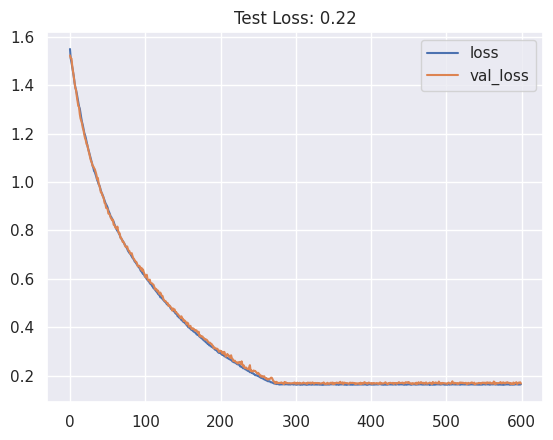

In [54]:
from tqdm import tqdm

history = {
    "loss":[],
    "val_loss":[]
}

model = cnn()
model = model.to(device_)

epochs = 600
lr_ = 0.001

optimizer = optim.Adam(model.parameters(),lr=lr_)
learning_rate = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.1, patience=5)
loss_fn = nn.SmoothL1Loss()

l1_lambda = 0
l2_lambda = 0.005

train_loss, val_loss = [], []

for e in tqdm(range(epochs)):

  running_loss = 0.0
  val_running_loss = 0.0
  steps = 0

  for i in range(3):

    indices = torch.randperm(X_train.size()[0])[:train_batch_size]

    x_ = X_train[indices,::].to(torch.float)
    x_ = abs(torch.fft.fft2(x_))
    y_ = y_train[indices,::].to(torch.float)

    x_ = x_.to(device_)
    y_ = y_.to(device_)

    model =model.train()

    optimizer.zero_grad()

    y_est = model(x_)
    y_est = y_est.requires_grad_(True)

    loss = loss_fn(y_est,y_)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
    loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
    running_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    steps += 1

    # if steps == 5:
    #   break

  running_loss /= steps
  history["loss"].append(running_loss)

  val_running_loss = 0.0
  steps = 0

  for i in range(5):

    indices = torch.randperm(X_val.size()[0])[:val_batch_size]

    x_val = X_val[indices,::].to(torch.float)
    x_val = abs(torch.fft.fft2(x_val))
    y_val_ = y_val[indices,::].to(torch.float)

    x_val = x_val.to(device_)
    y_val_ = y_val_.to(device_)

    model = model.eval()
    y_est = model(x_val)

    loss = loss_fn(y_est,y_val_)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
    loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
    val_running_loss += loss.item()

    steps += 1

    # if steps == 5:
    #   break


  val_running_loss /= steps
  history["val_loss"].append(val_running_loss)

  learning_rate.step(val_running_loss)
  last_lr = learning_rate.get_last_lr()

  print("----------------------------------------------------------------------------------")
  print(f"Epoch: {e}/{epochs} | loss: {running_loss:.2f} |  validation loss: {val_running_loss:.2f} | learning rate: {last_lr}")

model = model.eval()

y_ = model(X_test)
y_test = y_test.requires_grad_(True)

loss = loss_fn(y_test,y_)
l1_norm = sum(p.abs().sum() for p in model.parameters())
l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
print("------------------------------------------------------------------------------------")
print(f"Test Loss: {loss.item():.2f}")
print("------------------------------------------------------------------------------------")

print("Loss")
print(" ")
import matplotlib.pyplot as plt

plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val_loss")

plt.title(f"Test Loss: {loss.item():.2f}")

plt.grid()
plt.legend()



R-squared: 0.54


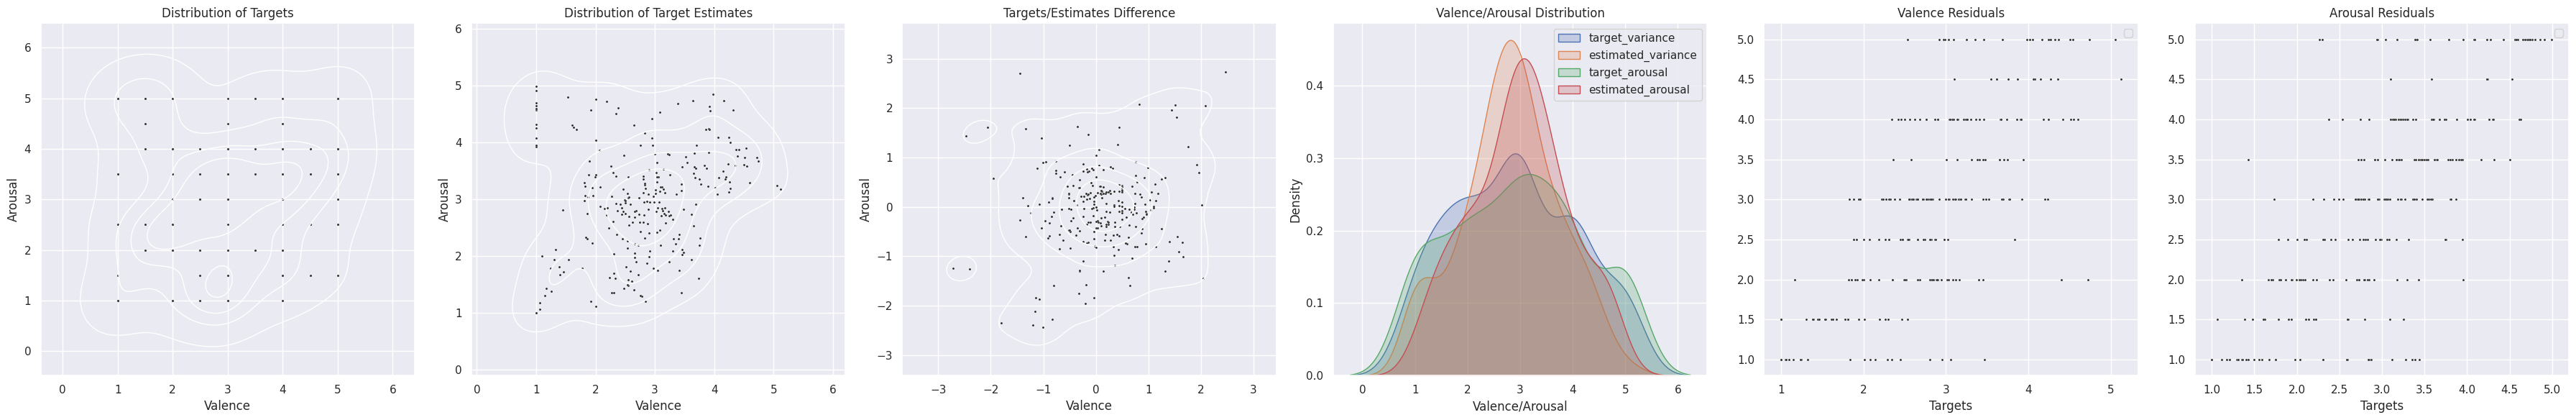

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

fig, ax_  = plt.subplots(1,6,figsize=(36,6))

# X_test = torch.tensor(X_test).to(float)
# y_test = torch.tensor(y_test).to(float)

y = feature_scaler.inverse_transform(y_test.detach().numpy())

sns.scatterplot(x=y[:,0], y=y[:,1], s=5, color=".15", ax=ax_[0])
# sns.histplot(x=y[:,0], y=y[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[0])
sns.kdeplot(x=y[:,0], y=y[:,1], levels=5, color="w", linewidths=1, ax=ax_[0])

model = model.eval()

y_est = model(abs(torch.fft.fft2(X_test)))
y_est = y_est.detach().numpy()
y_est = feature_scaler.inverse_transform(y_est)

sns.scatterplot(x=y_est[:,0], y=y_est[:,1], s=5, color=".15", ax=ax_[1])
# sns.histplot(x=y_est[:,0], y=y_est[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[1])
sns.kdeplot(x=y_est[:,0], y=y_est[:,1], levels=5, color="w", linewidths=1, ax=ax_[1])

distance = feature_scaler.inverse_transform(y_test.detach().numpy())-y_est
sns.scatterplot(x=distance[:,0], y=distance[:,1], s=5, color=".15", ax=ax_[2])
# sns.histplot(x=distance[:,0], y=distance[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[2])
sns.kdeplot(x=distance[:,0], y=distance[:,1], levels=5, color="w", linewidths=1, ax=ax_[2])

sns.kdeplot(x=y[:,0],ax=ax_[3],label="target_variance",fill=True,multiple="layer")
sns.kdeplot(x=y_est[:,0],ax=ax_[3],label="estimated_variance",fill=True,multiple="layer")
sns.kdeplot(x=y[:,1],ax=ax_[3],label="target_arousal",fill=True,multiple="layer")
sns.kdeplot(x=y_est[:,1],ax=ax_[3],label="estimated_arousal",fill=True,multiple="layer")

sns.scatterplot(x=y_est[:,0], y=y[:,0], s=5, color=".15", ax=ax_[4])

sns.scatterplot(x=y_est[:,1], y=y[:,1], s=5, color=".15", ax=ax_[5])

ax_[0].set_title("Distribution of Targets")
ax_[0].set_xlabel("Valence")
ax_[0].set_ylabel("Arousal")
ax_[0].grid()

ax_[1].set_title("Distribution of Target Estimates")
ax_[1].set_xlabel("Valence")
ax_[1].set_ylabel("Arousal")
ax_[1].grid()

ax_[2].set_title("Targets/Estimates Difference")
ax_[2].set_xlabel("Valence")
ax_[2].set_ylabel("Arousal")
ax_[2].grid()

ax_[3].set_xlabel("Valence/Arousal")
ax_[3].set_title("Valence/Arousal Distribution")
ax_[3].legend()
ax_[3].grid()

ax_[4].set_xlabel("Estimates")
ax_[4].set_xlabel("Targets")
ax_[4].set_title("Valence Residuals")
ax_[4].legend()
ax_[4].grid()

ax_[5].set_xlabel("Estimates")
ax_[5].set_xlabel("Targets")
ax_[5].set_title("Arousal Residuals")
ax_[5].legend()
ax_[5].grid()

fig.tight_layout()

print(f"R-squared: {r_squared(model(abs(torch.fft.fft2(X_test))),y_test):.2f}")

Text(0.5, 1.0, 'Correlation of targets and estimates')

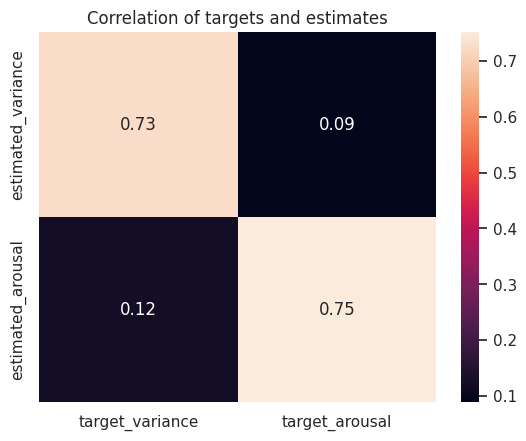

In [56]:
y_est = model(abs(torch.fft.fft2(X_test))).detach().numpy()
y_est = feature_scaler.inverse_transform(y_est)

target = y_test.clone()
target = target.detach().numpy()
target = feature_scaler.inverse_transform(target)

corr_ = np.empty((2,2))

corr_[0,0] = np.corrcoef(
    y_est[:,0],
    target[:,0],
    rowvar=False
)[0,1]

corr_[1,1] = np.corrcoef(
    y_est[:,1],
    target[:,1],
    rowvar=False
)[0,1]

corr_[0,1] = np.corrcoef(
    y_est[:,0],
    target[:,1],
    rowvar=False
)[0,1]

corr_[1,0] = np.corrcoef(
    y_est[:,1],
    target[:,0],
    rowvar=False
)[0,1]

sns.heatmap(corr_,xticklabels=["target_variance","target_arousal"],yticklabels=["estimated_variance","estimated_arousal"],annot=True)
plt.title("Correlation of targets and estimates")

In [57]:
def checkpoint_model(model,name,test_performance):
  model_ = {
      "model":model,
      "model_weights":model.state_dict(),
      "performance":test_performance
  }
  joblib.dump(model_,name)

In [58]:
checkpoint_model(model=model,name="cnn_21.sav",test_performance="0.22 Test SmoothL1 Loss")